MAFS6010Z Project1
<br />Ni Jianle contribution: Data Processing+Data Exploration+lgbm+random forest
<br />Liu Minghao contribution:

In [1]:
import numpy as np 
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import lightgbm as lgb
import re
from sklearn.model_selection import KFold  
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
training_dataset=pd.read_csv(r"C:\Users\jenny\Documents\application_train.csv")
testing_dataset=pd.read_csv(r"C:\Users\jenny\Documents\application_test.csv")
training_dataset.shape
testing_dataset.shape
training_dataset.columns

Index(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY',
       ...
       'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20',
       'FLAG_DOCUMENT_21', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_YEAR'],
      dtype='object', length=122)

In [2]:
TestId=testing_dataset["SK_ID_CURR"]
labels=training_dataset["TARGET"]

First we explored the data for NaN and outliers, we found 67 columns of data with NaN, then we used "DAYS_BIRTH"/-365 for age and found that there were no outliers in age." The outliers in the "DAYS_EMPLOYED" column are all positive and are 365243, which we processed.

In [3]:
missing_proportion=training_dataset.isnull().sum()/training_dataset.shape[0]
missing_proportion[missing_proportion.values>0].sort_values(ascending=False)

COMMONAREA_MEDI             0.698723
COMMONAREA_AVG              0.698723
COMMONAREA_MODE             0.698723
NONLIVINGAPARTMENTS_MEDI    0.694330
NONLIVINGAPARTMENTS_MODE    0.694330
                              ...   
EXT_SOURCE_2                0.002146
AMT_GOODS_PRICE             0.000904
AMT_ANNUITY                 0.000039
CNT_FAM_MEMBERS             0.000007
DAYS_LAST_PHONE_CHANGE      0.000003
Length: 67, dtype: float64

<AxesSubplot:>

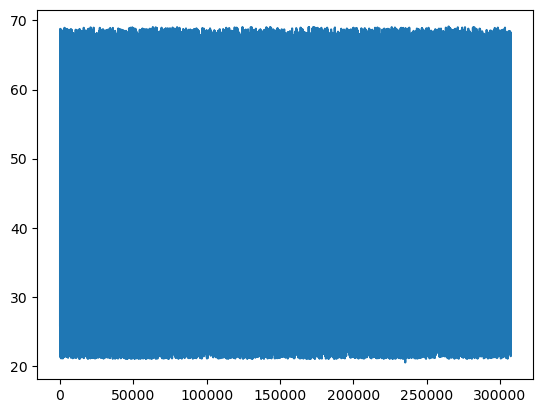

In [4]:
(training_dataset["DAYS_BIRTH"]/-365).plot()#No outliers found for age

In [5]:
training_dataset["DAYS_EMPLOYED"].value_counts().sort_values()

-8694          1
-16266         1
-14743         1
-9556          1
-9281          1
           ...  
-199         151
-230         151
-224         152
-200         156
 365243    55374
Name: DAYS_EMPLOYED, Length: 12574, dtype: int64

In [6]:
training_dataset["DAYS_EMPLOYED"].replace({365243:np.nan},inplace=True)

We then explored the dataset. The first finding is that this classification problem is unbalanced. When exploring the distribution of default rates for males and females, it was found that males had a higher default rate. When exploring the relationship between age and default, it was found that younger people were more heavily represented among defaulting users.

<AxesSubplot:>

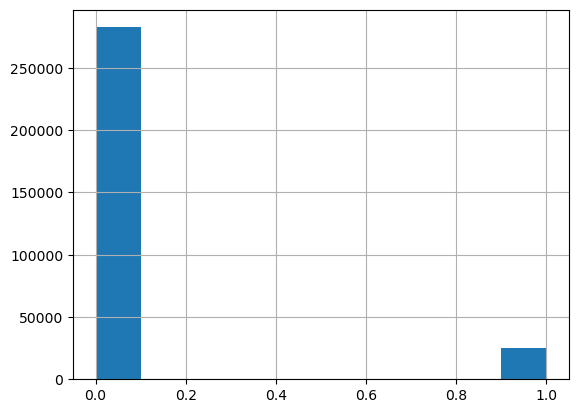

In [7]:
training_dataset["TARGET"].hist()

In [8]:
training_dataset.groupby("CODE_GENDER")["TARGET"].sum()/training_dataset.groupby("CODE_GENDER")["TARGET"].count()#Exploring the distribution of default rates for males and females reveals that males have higher default rates.

CODE_GENDER
F      0.069993
M      0.101419
XNA    0.000000
Name: TARGET, dtype: float64

<AxesSubplot:>

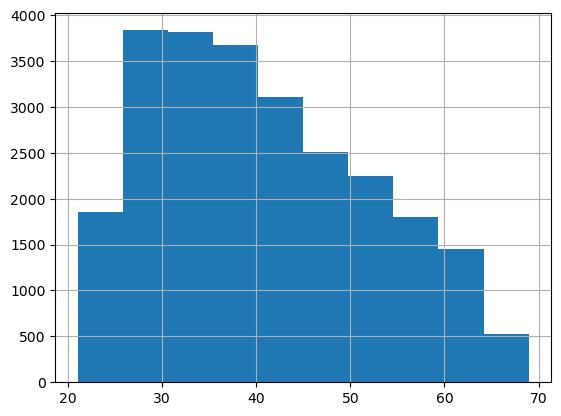

In [9]:

(training_dataset[training_dataset["TARGET"]==1]["DAYS_BIRTH"]/-365).hist()

<AxesSubplot:>

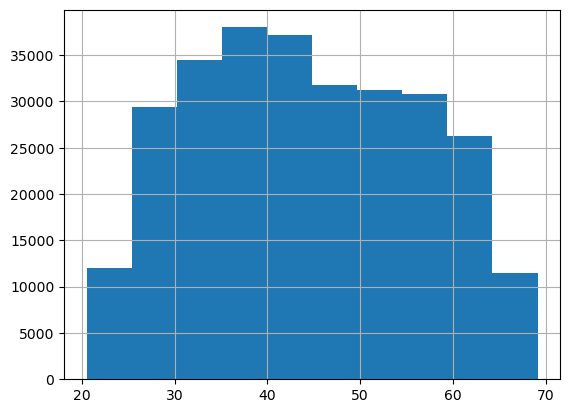

In [10]:
(training_dataset[training_dataset["TARGET"]==0]["DAYS_BIRTH"]/-365).hist()

We experimented with two new features based on the original data: repay_period and whether the customer did not fill in housing information. The repay_period is expressed as the customer's total loan amount/annual repayment amount, guessing that a long repayment cycle is relatively low financial pressure and less likely to default. We label customers with no missing housing information as 0 and missing as 1, guessing that the housing information is missing and the possibility of default is high. By calculating the correlation coefficients between the new features and TARGET, we found that the absolute values of the correlation coefficients of the new features are all improved than the old features. We convert the columns in the training set of type object to a computer understandable type using one hot encoding.

In [11]:
training_dataset["repay_period"]=training_dataset["AMT_CREDIT"]/training_dataset["AMT_ANNUITY"]
training_dataset["house_info"]=training_dataset["COMMONAREA_MEDI"].apply(lambda x:0 if x>0 else 1)

In [12]:
testing_dataset["repay_period"]=testing_dataset["AMT_CREDIT"]/testing_dataset["AMT_ANNUITY"]
testing_dataset["house_info"]=testing_dataset["COMMONAREA_MEDI"].apply(lambda x:0 if x>0 else 1)

In [13]:
training_dataset[["TARGET","AMT_CREDIT","AMT_ANNUITY","COMMONAREA_MEDI"]].corr()

,TARGET,AMT_CREDIT,AMT_ANNUITY,COMMONAREA_MEDI
TARGET,1.000000,-0.030369,-0.012817,-0.018573
AMT_CREDIT,-0.030369,1.000000,0.770138,0.048565
AMT_ANNUITY,-0.012817,0.770138,1.000000,0.056865
COMMONAREA_MEDI,-0.018573,0.048565,0.056865,1.000000


In [14]:
training_dataset[["TARGET","repay_period","house_info"]].corr()

,TARGET,repay_period,house_info
TARGET,1.000000,-0.032102,0.025471
repay_period,-0.032102,1.000000,-0.009456
house_info,0.025471,-0.009456,1.000000


In [15]:
training_dataset.dtypes

SK_ID_CURR                      int64
TARGET                          int64
NAME_CONTRACT_TYPE             object
CODE_GENDER                    object
FLAG_OWN_CAR                   object
                               ...   
AMT_REQ_CREDIT_BUREAU_MON     float64
AMT_REQ_CREDIT_BUREAU_QRT     float64
AMT_REQ_CREDIT_BUREAU_YEAR    float64
repay_period                  float64
house_info                      int64
Length: 124, dtype: object

In [16]:
def ohe(training,testing):
    #one hot encoding
    training=training.drop(columns=["SK_ID_CURR", "TARGET"])
    del testing["SK_ID_CURR"]
    training=pd.get_dummies(training)
    testing=pd.get_dummies(testing)
    #用inner的方式连接
    training,testing=training.align(testing, join="inner", axis=1)
    return training,testing

In [17]:
train,test=ohe(training_dataset,testing_dataset)
test=test.rename(columns=lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [18]:
model=lgb.LGBMClassifier(objective="binary")
model.fit(train,labels)
itera=model.best_iteration_
pred=model.predict_proba(test,num_iteration=itera)[:,1]

In [19]:
pred

array([0.0331725 , 0.0980342 , 0.01679349, ..., 0.0235074 , 0.043862  ,
       0.2486484 ])

In [20]:
submission=pd.DataFrame({"SK_ID_CURR":TestId, "TARGET":pred})
submission.to_csv("submit_lgbm.csv",index=False)

In [21]:
for i in train.columns:
    train.fillna(train[i].median(), inplace=True)
sum(np.isnan(train).any())

0

In [22]:
np.isfinite(train).all()

CNT_CHILDREN                       True
AMT_INCOME_TOTAL                   True
AMT_CREDIT                         True
AMT_ANNUITY                        True
AMT_GOODS_PRICE                    True
                                   ... 
WALLSMATERIAL_MODE_Panel           True
WALLSMATERIAL_MODE_Stone, brick    True
WALLSMATERIAL_MODE_Wooden          True
EMERGENCYSTATE_MODE_No             True
EMERGENCYSTATE_MODE_Yes            True
Length: 243, dtype: bool

In [23]:
train_inf=np.isinf(train)
train[train_inf]=0

In [24]:
for i in test.columns:
    test.fillna(test[i].median(),inplace=True)

In [25]:
test_inf=np.isinf(test)
test[test_inf]=0

In [26]:
random_forest=RandomForestClassifier()
random_forest.fit(train,labels)

RandomForestClassifier()

In [27]:
pred_rf=random_forest.predict_proba(test)[:, 1]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- FONDKAPREMONT_MODE_notspecified
- FONDKAPREMONT_MODE_orgspecaccount
- FONDKAPREMONT_MODE_regoperaccount
- FONDKAPREMONT_MODE_regoperspecaccount
- HOUSETYPE_MODE_blockofflats
- ...
Feature names seen at fit time, yet now missing:
- FONDKAPREMONT_MODE_not specified
- FONDKAPREMONT_MODE_org spec account
- FONDKAPREMONT_MODE_reg oper account
- FONDKAPREMONT_MODE_reg oper spec account
- HOUSETYPE_MODE_block of flats
- ...

  warnings.warn(message, FutureWarning)


In [28]:
pd.concat([pd.DataFrame(TestId),pd.DataFrame(pred_rf,columns=["TARGET"])],axis=1).to_csv("submit_rf.csv",index=False)